# Projeto

## Modeling

In [2]:
import pandas as pd
import numpy as np
import dslabs_functions as dslabs
from matplotlib.pyplot import figure, show, subplots, plot, legend, savefig
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from torch import no_grad, tensor
from torch.nn import LSTM, Linear, Module, MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from copy import deepcopy

In [3]:
### Plotting UNIVARIATE Time Series
file_tag = "traffic"
target = "Total"
index="Timestamp"
### ordenar dados no csv ou nao e preciso??? last timestamp esta mal pq dados no csv nao estao ordenados por data
original_data: pd.DataFrame = pd.read_csv(
    "forecast_traffic_single.csv",
    index_col="Timestamp",
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)

In [4]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler


def scale_all_dataframe_log(data: pd.DataFrame) -> pd.DataFrame:
    # Apply log transformation
    df = np.log(data)
    
    # Create a new DataFrame with the same index and columns
    df = pd.DataFrame(df, index=data.index)
    df.columns = data.columns.to_list()
    
    return df

def scale_all_dataframe(data: pd.DataFrame) -> pd.DataFrame:
    vars: list[str] = data.columns.to_list()
    transf: RobustScaler = RobustScaler().fit(data)
    df = pd.DataFrame(transf.transform(data), index=data.index)
    df.columns = vars
    return df

In [5]:
### Sort 'TimeStamp' Ascending
original_data.sort_index(inplace=True)

#original_data.index = pd.to_datetime(original_data.index)
#original_data.to_csv("sorted_forecast_traffic.csv")
data = original_data.copy()

series_og: pd.Series = original_data[target]

# Output the inferred frequency
inferred_freq = pd.infer_freq(series_og.index)
print("Inferred frequency of the DateTimeIndex: ", inferred_freq)

print("Nr. Records = ", series_og.shape[0])
print("First timestamp", series_og.index[0])
print("Last timestamp", series_og.index[-1])

## Using atomic granularity

### Smoothing
WIN_SIZE = 16
ss_smooth: pd.Series = series_og.rolling(WIN_SIZE).mean()
ss_smooth.bfill(inplace=True)
print(ss_smooth.describe())
### Differentiation
ss_diff: pd.Series = ss_smooth.diff()
ss_diff.bfill(inplace=True)

### Scaling useful for LSTMs
data[target] = ss_smooth

data_scaled: pd.DataFrame = scale_all_dataframe(data)
series_data: pd.Series = data_scaled[target]

Inferred frequency of the DateTimeIndex:  15T
Nr. Records =  2976
First timestamp 2023-10-01 00:00:00
Last timestamp 2023-10-31 23:45:00
count    2976.000000
mean      114.174920
std        46.712804
min        36.687500
25%        75.921875
50%       112.437500
75%       154.875000
max       242.187500
Name: Total, dtype: float64


{'RMSE': [0.47855510317794625, 0.4410484931596005], 'MAE': [0.39633975052861, 0.36052153124484543]} {'MAPE': [0.08966217113755451, 0.08102938743188598], 'R2': [5.463670167427104e-05, -0.00025210417644783156]}


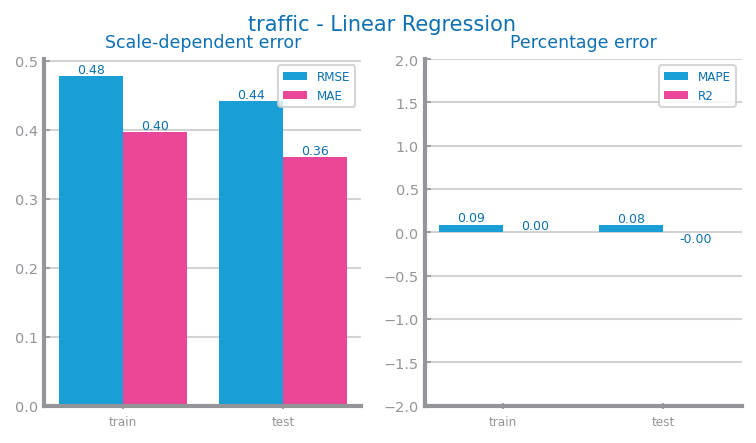

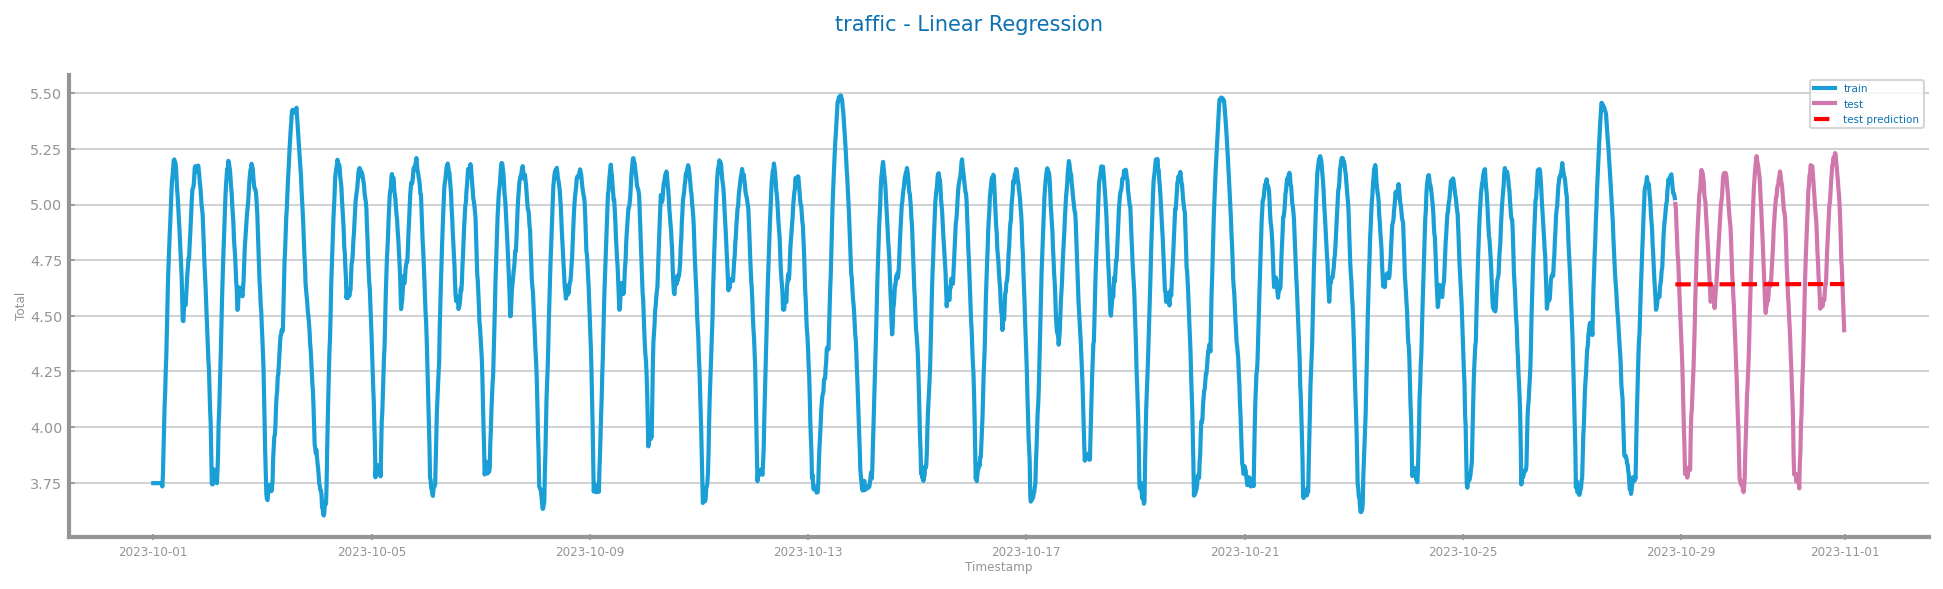

In [69]:
train_diff_2, test_diff_2 = dslabs.dataframe_temporal_train_test_split(data_scaled, trn_pct=0.90)

trnX_diff_2 = np.arange(len(train_diff_2)).reshape(-1, 1)
trnY_diff_2 = train_diff_2.to_numpy().ravel()

tstX_diff_2 = np.arange(len(train_diff_2), len(data_scaled)).reshape(-1, 1)
tstY_diff_2 = test_diff_2.to_numpy().ravel()

model = LinearRegression()
model.fit(trnX_diff_2, trnY_diff_2)

prd_trn_diff_2: pd.Series = pd.Series(model.predict(trnX_diff_2), index=train_diff_2.index)
prd_tst_diff_2: pd.Series = pd.Series(model.predict(tstX_diff_2), index=test_diff_2.index)

dslabs.plot_forecasting_eval(train_diff_2, test_diff_2, prd_trn_diff_2, prd_tst_diff_2, title=f"{file_tag} - Linear Regression")

dslabs.plot_forecasting_series(
    train_diff_2,
    test_diff_2,
    prd_tst_diff_2,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
show()

<Axes: title={'center': 'traffic Total after scaling'}, xlabel='Timestamp', ylabel='Total'>

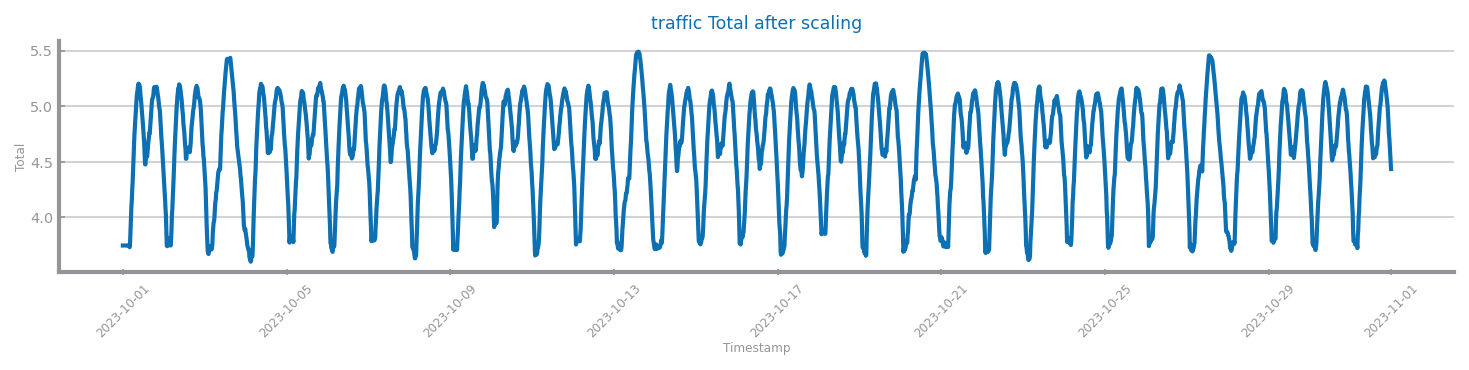

In [70]:
figure(figsize=(3 * dslabs.HEIGHT, dslabs.HEIGHT / 2))
dslabs.plot_line_chart(
    series_data.index.to_list(),
    series_data.to_list(),
    xlabel=series_data.index.name,
    ylabel=target,
    title=f"{file_tag} {target} after scaling",
)

## Simple Average Model

*always predicting the outcome to be the data mean value*

In [22]:
from sklearn.base import RegressorMixin

class SimpleAvgRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.mean: float = 0.0
        return

    def fit(self, X: pd.Series):
        self.mean = X.mean()
        return

    def predict(self, X: pd.Series) -> pd.Series:
        prd: list = len(X) * [self.mean]
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [47.12057930979815, 42.78917726902345], 'MAE': [40.01840336593191, 36.61621445684699]} {'MAPE': [0.49396324828108695, 0.4404240401921858], 'R2': [0.0, -1.563727442555063e-05]}


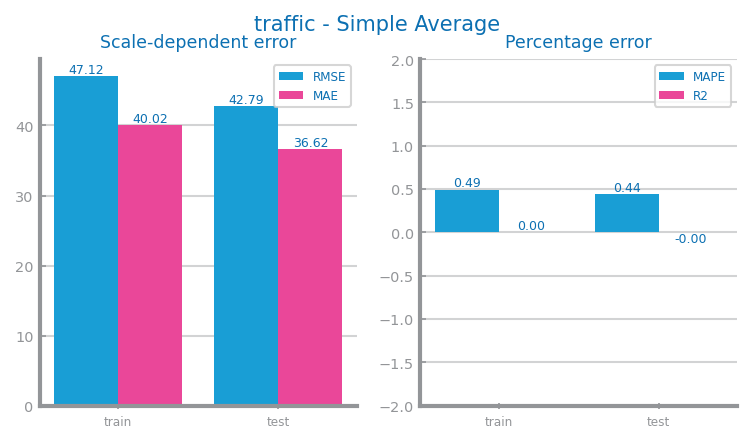

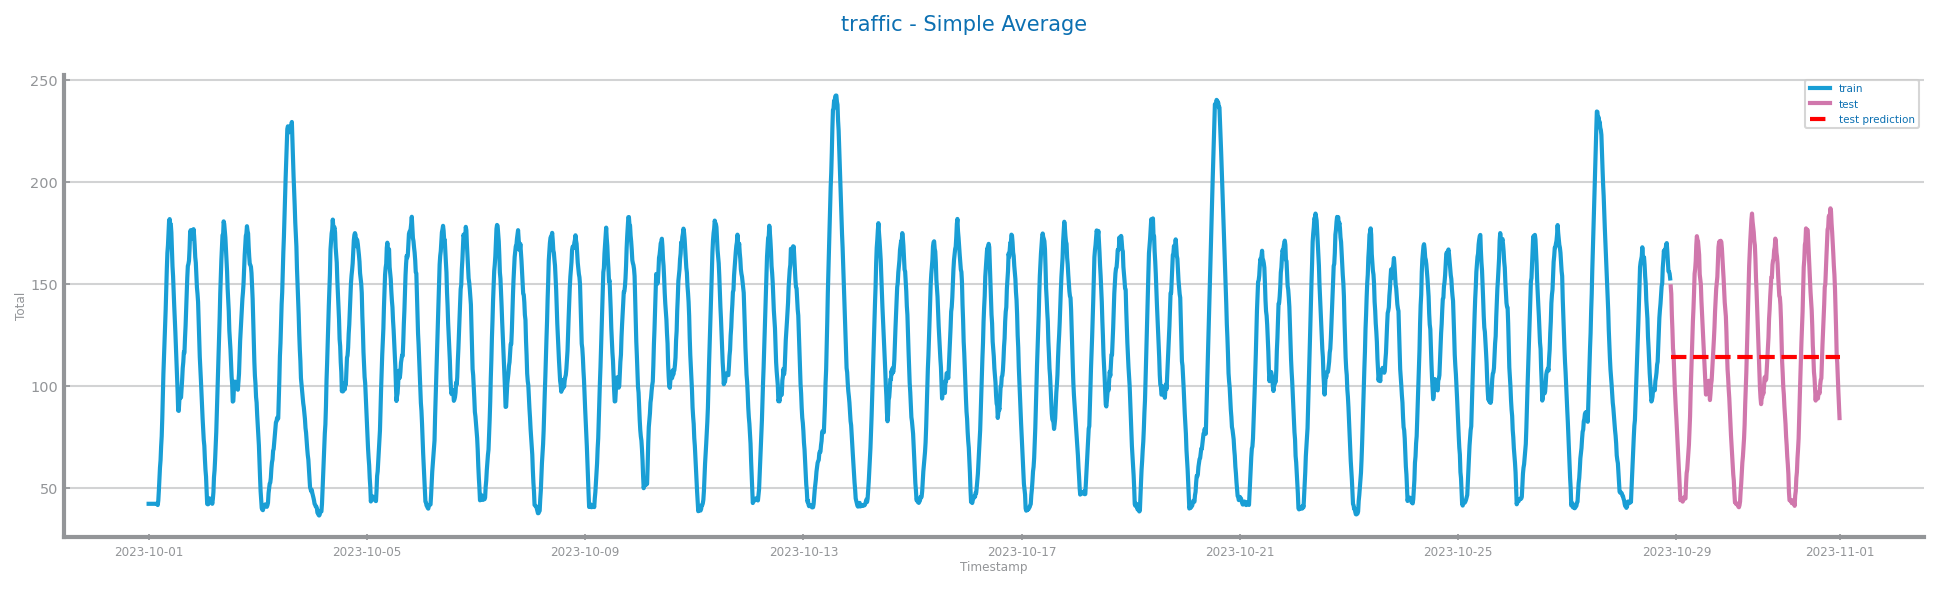

In [75]:
train_sam, test_sam = dslabs.series_train_test_split(data, trn_pct=0.90)

trnX_sam = np.arange(len(train_sam)).reshape(-1, 1)
trnY_sam = train_sam.to_numpy()

tstX = np.arange(len(train_sam), len(data)).reshape(-1, 1)
tstY = test_sam.to_numpy()

fr_mod = SimpleAvgRegressor()
fr_mod.fit(train_sam)
prd_trn_sam: pd.Series = fr_mod.predict(train_sam)
prd_tst_sam: pd.Series = fr_mod.predict(test_sam)

dslabs.plot_forecasting_eval(train_sam, test_sam, prd_trn_sam, prd_tst_sam, title=f"{file_tag} - Simple Average")
savefig("../forecasting_services/modeling_images/results_Simple_Average", bbox_inches='tight')

dslabs.plot_forecasting_series(
    train_sam,
    test_sam,
    prd_tst_sam,
    title=f"{file_tag} - Simple Average",
    xlabel="Timestamp",
    ylabel=target,
)
savefig("../forecasting_services/modeling_images/plot_Simple_Average", bbox_inches='tight')
show()

## Persistence Model

In [27]:
class PersistenceOptimistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last: float = 0.0
        return

    def fit(self, X: pd.Series):
        self.last = X.iloc[-1]
        # print(self.last)
        return

    def predict(self, X: pd.Series):
        prd: list = X.shift().values.ravel()
        prd[0] = self.last
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [5.874255361339346, 5.591237929990558], 'MAE': [4.635455563853622, 4.803481543624161]} {'MAPE': [0.044978619867641144, 0.04572033111818181], 'R2': [0.9844588052887898, 0.9829252298517116]}


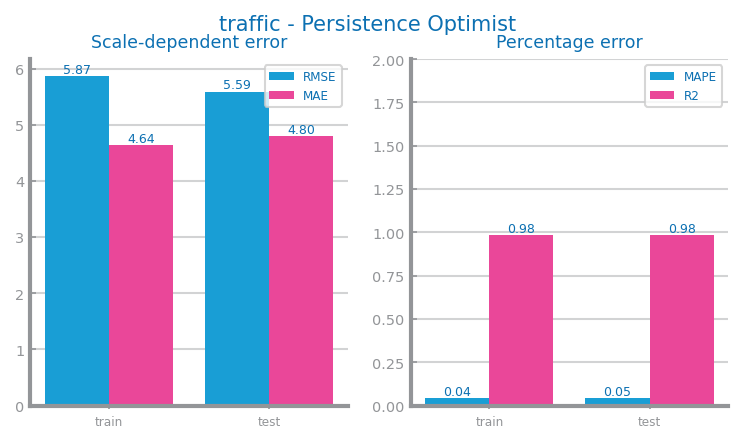

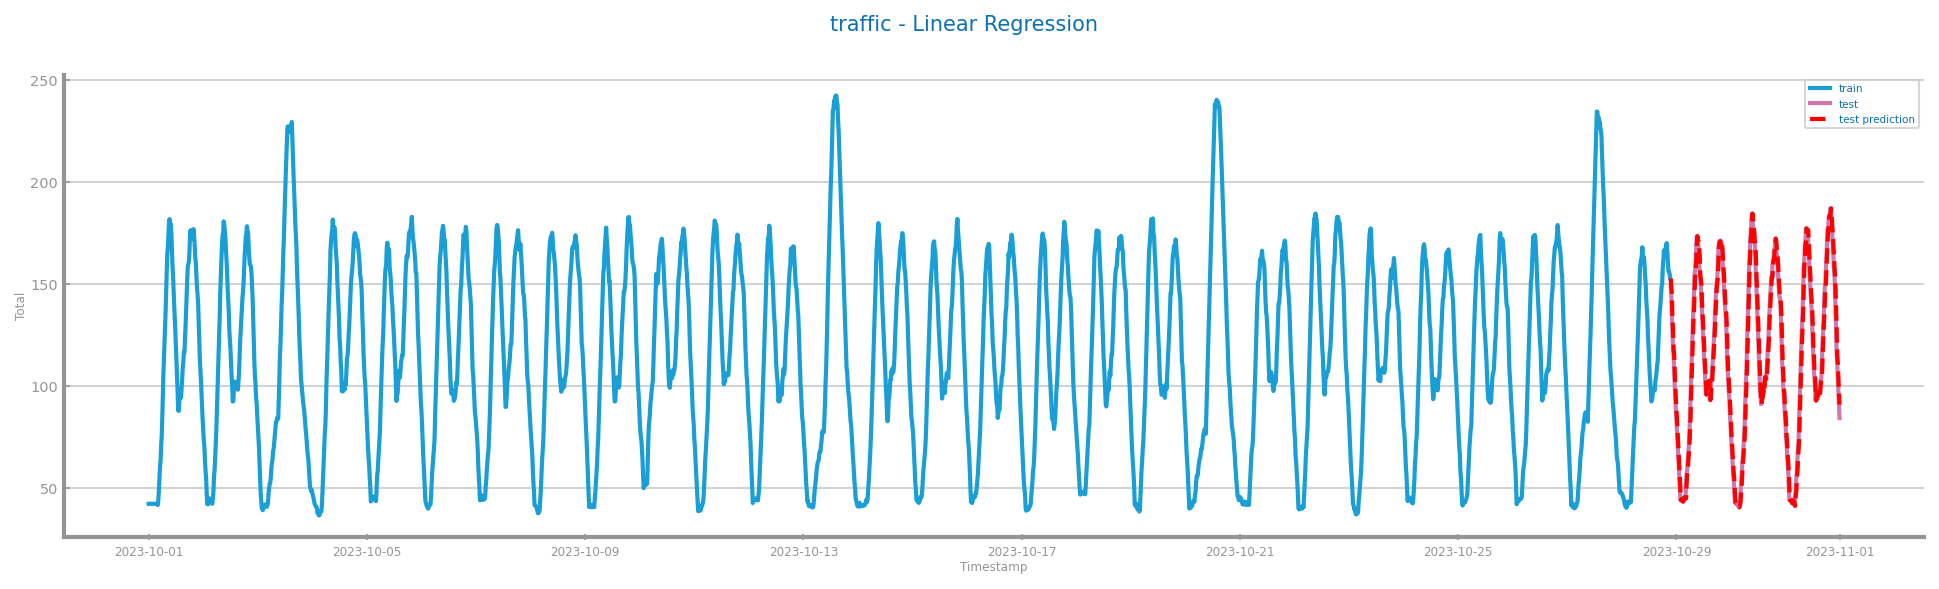

In [78]:
# Figure 88 Forecasting plots obtained with Persistence model (long term) over time series 2
# PersistenceOptimistRegressor REALISTA MUDAR ISTO
train_pm, test_pm = dslabs.series_train_test_split(data, trn_pct=0.90)

fr_mod = PersistenceOptimistRegressor()
fr_mod.fit(train_pm)
prd_trn_pm: pd.Series = fr_mod.predict(train_pm)
prd_tst_pm: pd.Series = fr_mod.predict(test_pm)

dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Optimist")
savefig("../forecasting_services/modeling_images/results_one_set_behind", bbox_inches='tight')

dslabs.plot_forecasting_series(
    train_pm,
    test_pm,
    prd_tst_pm,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
savefig("../forecasting_services/modeling_images/plot_one_set_behind", bbox_inches='tight')
show()

In [29]:
class PersistenceRealistRegressor(RegressorMixin):
    def __init__(self):
        super().__init__()
        self.last = 0
        self.estimations = [0]
        self.obs_len = 0

    def fit(self, X: pd.Series):
        for i in range(1, len(X)):
            self.estimations.append(X.iloc[i - 1])
        self.obs_len = len(self.estimations)
        self.last = X.iloc[len(X) - 1]
        prd_series: pd.Series = pd.Series(self.estimations)
        prd_series.index = X.index
        return prd_series

    def predict(self, X: pd.Series):
        prd: list = len(X) * [self.last]
        prd_series: pd.Series = pd.Series(prd)
        prd_series.index = X.index
        return prd_series

{'RMSE': [0.6194405568372858, 0.5792816611385782], 'MAE': [0.4548067878618503, 0.42240105793163485]} {'MAPE': [0.10923116566611883, 0.10044714779114894], 'R2': [-0.6753734958148161, -0.725505500479732]}


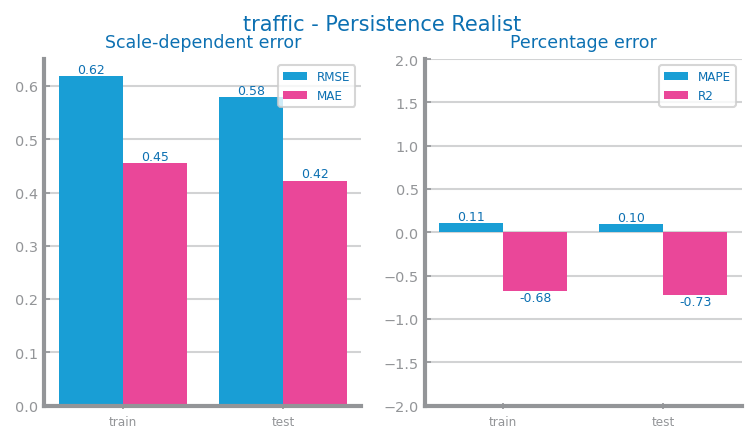

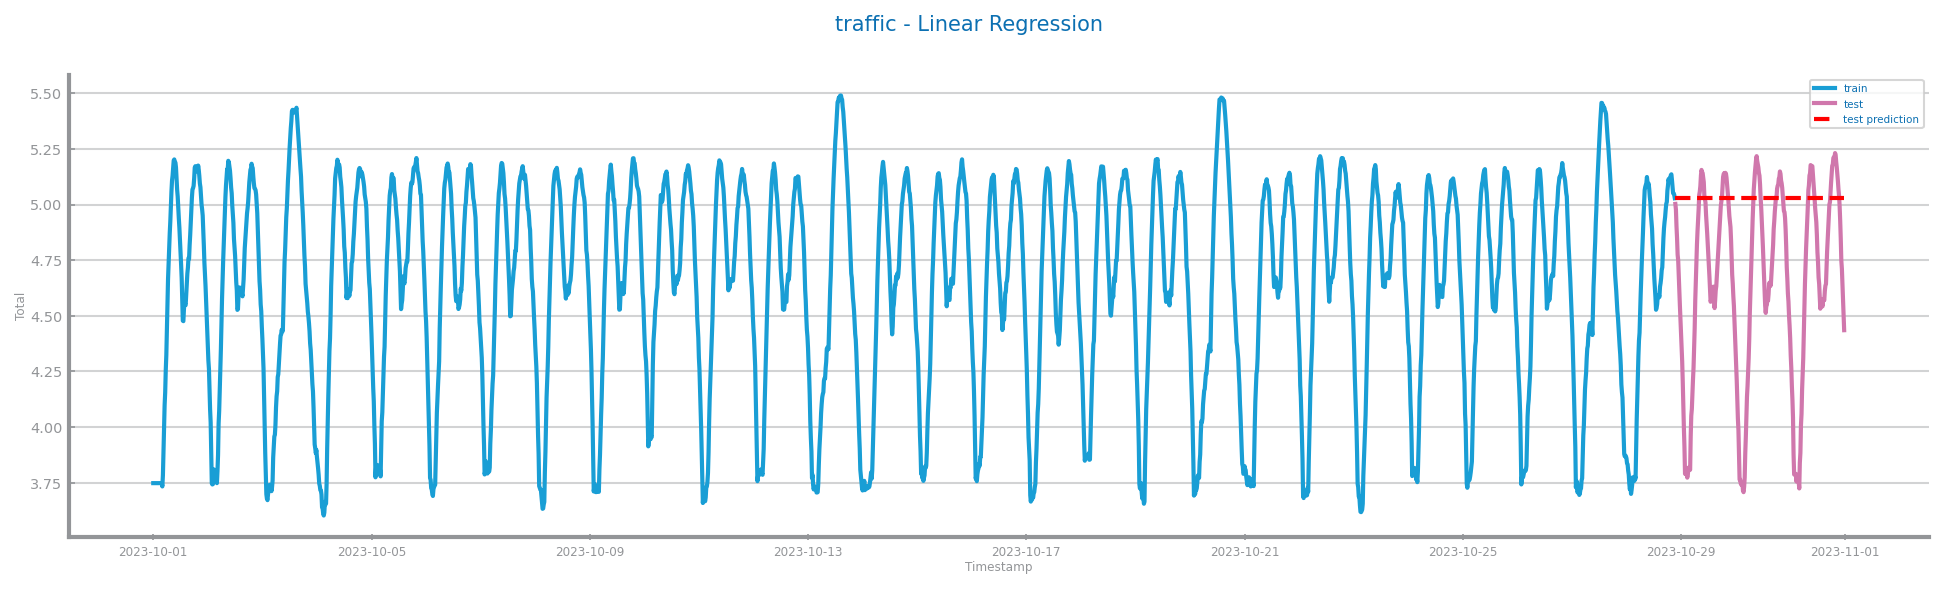

In [111]:
# Figure 89 Forecasting plots obtained with Persistence model (one-set-behind) over time series 2
# PersistenceRealistRegressor
train_pm, test_pm = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

fr_mod = PersistenceRealistRegressor()
fr_mod.fit(train_pm)
prd_trn_pm: pd.Series = fr_mod.predict(train_pm)
prd_tst_pm: pd.Series = fr_mod.predict(test_pm)

dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Realist")
savefig("../forecasting_services/modeling_images/results_long_term", bbox_inches='tight')

dslabs.plot_forecasting_series(
    train_pm,
    test_pm,
    prd_tst_pm,
    title=f"{file_tag} - Linear Regression",
    xlabel="Timestamp",
    ylabel=target,
)
savefig("../forecasting_services/modeling_images/plot_long_term", bbox_inches='tight')
show()

In [31]:
# Figure 86 Forecasting results obtained with Persistence model in both situation over time series 2
# PersistenceOptimistRegressor && PersistenceRealistRegressor

# Assuming data_scaled is your prepared DataFrame and the series are already scaled
train_pm, test_pm = dslabs.series_train_test_split(data, trn_pct=0.90)

# Persistence Optimist Regressor
optimist_model = PersistenceOptimistRegressor()
optimist_model.fit(train_pm)
optimist_pred_train = optimist_model.predict(train_pm)
optimist_pred_test = optimist_model.predict(test_pm)

# Persistence Realist Regressor
realist_model = PersistenceRealistRegressor()
realist_model.fit(train_pm)
realist_pred_train = realist_model.predict(train_pm)
realist_pred_test = realist_model.predict(test_pm)

# Plotting
# dslabs.plot_forecasting_eval(train_pm, test_pm, prd_trn_pm, prd_tst_pm, title=f"{file_tag} - Persistence Optimist")

# dslabs.plot_forecasting_series(
#     train_pm,
#     test_pm,
#     prd_tst_pm,
#     title=f"{file_tag} - Linear Regression",
#     xlabel="Timestamp",
#     ylabel=target,
# )
# show()


## Rolling Mean Model

In [125]:
class RollingMeanRegressor(RegressorMixin):
    def __init__(self, win: int = 3):
        super().__init__()
        self.win_size = win
        self.memory: list = []

    def fit(self, X: pd.Series):
        self.memory = X.iloc[-self.win_size :]
        # print(self.memory)
        return

    def predict(self, X: pd.Series):
        estimations = self.memory.tolist()
        for i in range(len(X)):
            new_value = np.mean(estimations[len(estimations) - self.win_size - i :])
            estimations.append(new_value)
        prd_series: pd.Series = pd.Series(estimations[self.win_size :])
        prd_series.index = X.index
        return prd_series
    
def rolling_mean_study(train: pd.Series, test: pd.Series, measure: str = "R2"):
    #win_size = (3, 5, 10, 15, 20, 25, 30, 40, 50)
    win_size = (12, 24, 48, 96, 192, 384, 768)
    #win_size = [i for i in range(1, 400)]
    flag = measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = -100000

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = dslabs.FORECAST_MEASURES[measure](test, prd_tst)
        print(w, eval)
        if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    dslabs.plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

def rolling_mean_study_mape(train: pd.Series, test: pd.Series, measure: str = "MAPE"):
    win_size = [i for i in range(1, 400)]
    flag = measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "Rolling Mean", "metric": measure, "params": ()}
    best_performance: float = 100000  # Start with a high error value.

    yvalues = []
    for w in win_size:
        pred = RollingMeanRegressor(win=w)  # Assuming this is your rolling mean regressor.
        pred.fit(train)
        prd_tst = pred.predict(test)

        eval: float = dslabs.FORECAST_MEASURES[measure](test, prd_tst)
        print(w, eval)
        if eval < best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
            best_performance: float = eval
            best_params["params"] = (w,)
            best_model = pred
        yvalues.append(eval)

    print(f"Rolling Mean best with win={best_params['params'][0]:.0f} -> {measure}={best_performance}")
    dslabs.plot_line_chart(
        win_size, yvalues, title=f"Rolling Mean ({measure})", xlabel="window size", ylabel=measure, percentage=flag
    )

    return best_model, best_params

1 0.10044714779114901
2 0.1013948601121724
3 0.10197620121176983
4 0.10231057043541236
5 0.10323600799341011
6 0.10456485450199231
7 0.1060468634130659
8 0.10712162220731464
9 0.10773614608043196
10 0.10824121411234823
11 0.1084358268176168
12 0.10875978458020176
13 0.1087050168436488
14 0.10841746305319991
15 0.10767802568974902
16 0.10696457546491468
17 0.10612147309287626
18 0.10513539672836326
19 0.1041190442027464
20 0.10304728552875377
21 0.1018063947113545
22 0.10035303248546128
23 0.09878637747842609
24 0.0973454282633045
25 0.09596328530262793
26 0.09468916331468674
27 0.09350874410578308
28 0.09231104822923006
29 0.09127808221018856
30 0.09033257383273087
31 0.08955237541048261
32 0.08877871326761824
33 0.08805547007532145
34 0.08738433451703334
35 0.08686814289326047
36 0.08645957236452248
37 0.08614847807995367
38 0.08594807517290444
39 0.08583992091364448
40 0.08579734612147813
41 0.08584548689760144
42 0.08593228985492893
43 0.08605747138799305
44 0.08625025476897978
45 0

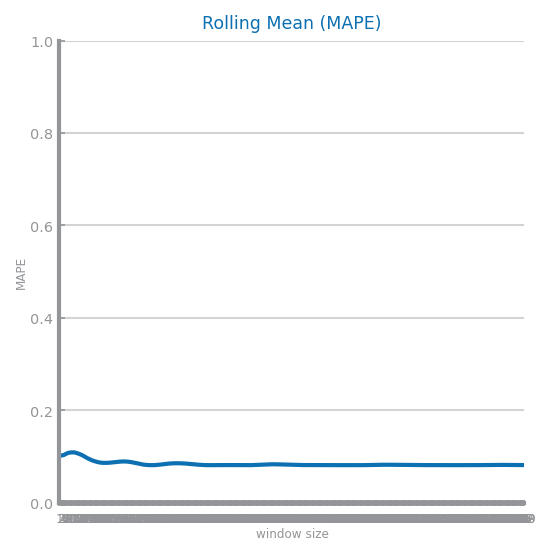

In [127]:
train, test = dslabs.series_train_test_split(data_scaled, trn_pct=0.90)

fig = figure(figsize=(dslabs.HEIGHT, dslabs.HEIGHT))
best_model, best_params = rolling_mean_study_mape(train, test)
print(best_model)

{'RMSE': [0.48597551357851987, 0.44603199026614143], 'MAE': [0.39017430037360135, 0.3552752485466188]} {'MAPE': [0.08995917500769465, 0.08125164821532505], 'R2': [-0.031195815831754015, -0.022983914483280632]}


array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

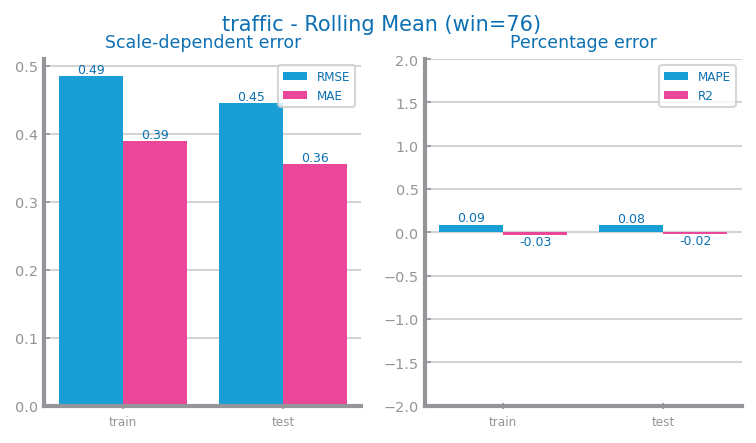

In [128]:
params = best_params["params"]
prd_trn: pd.Series = best_model.predict(train)
prd_tst: pd.Series = best_model.predict(test)

dslabs.plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Rolling Mean (win={params[0]})")

<Axes: xlabel='TimeStamp', ylabel='Total'>

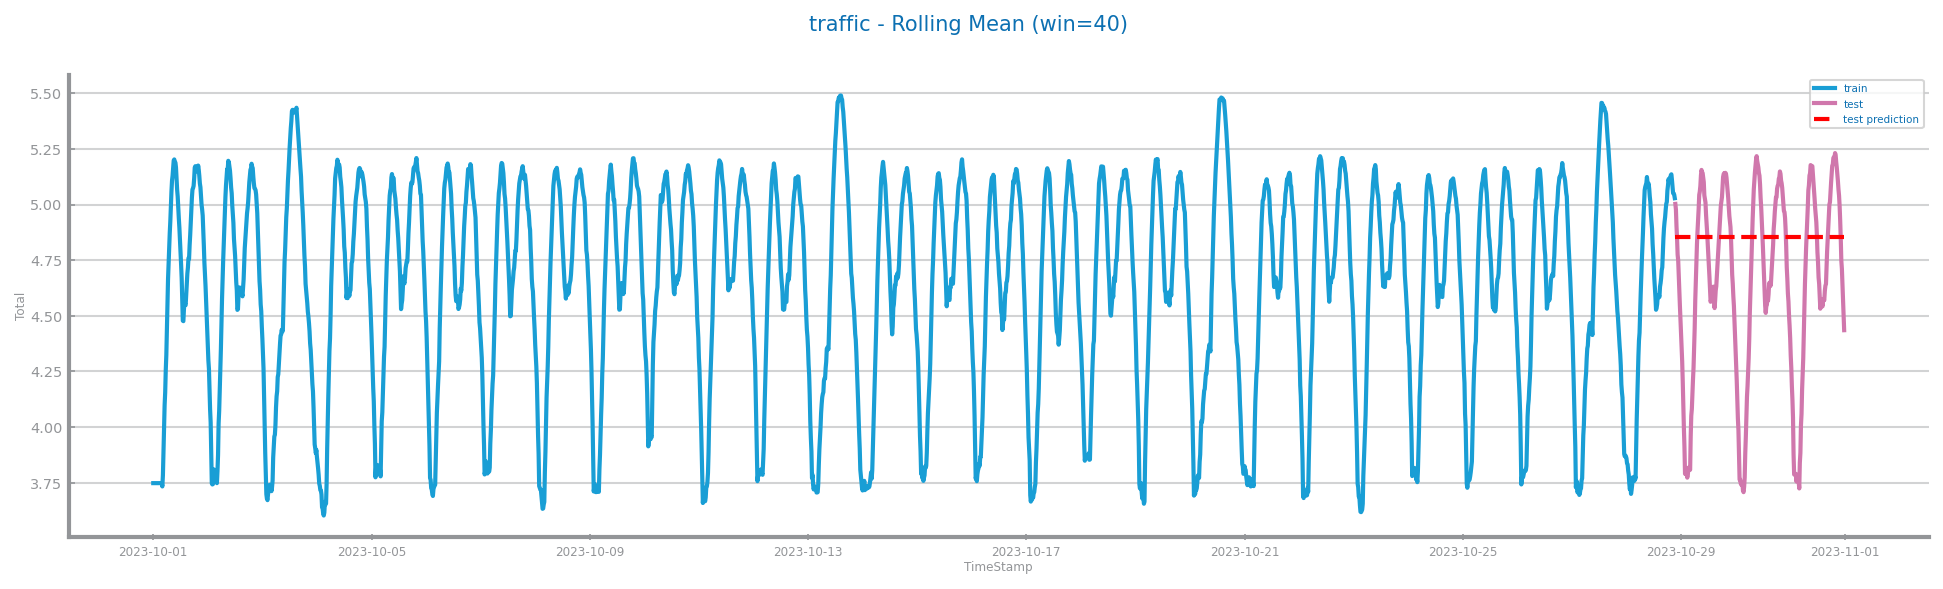

In [101]:
dslabs.plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Rolling Mean (win={params[0]})",
    xlabel="TimeStamp",
    ylabel=target,
)

## ARIMA Model

In [131]:
train, test = dslabs.series_train_test_split(data, trn_pct=0.90)

predictor = ARIMA(train, order=(2, 8, 4))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                 2678
Model:                 ARIMA(2, 8, 4)   Log Likelihood               -9906.263
Date:                Sat, 30 Dec 2023   AIC                          19826.525
Time:                        12:33:35   BIC                          19867.754
Sample:                    10-01-2023   HQIC                         19841.443
                         - 10-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7628      0.012   -149.432      0.000      -1.786      -1.740
ar.L2         -0.7981      0.012    -67.738      0.000      -0.821      -0.775
ma.L1         -1.9970      7.991     -0.250      0.8

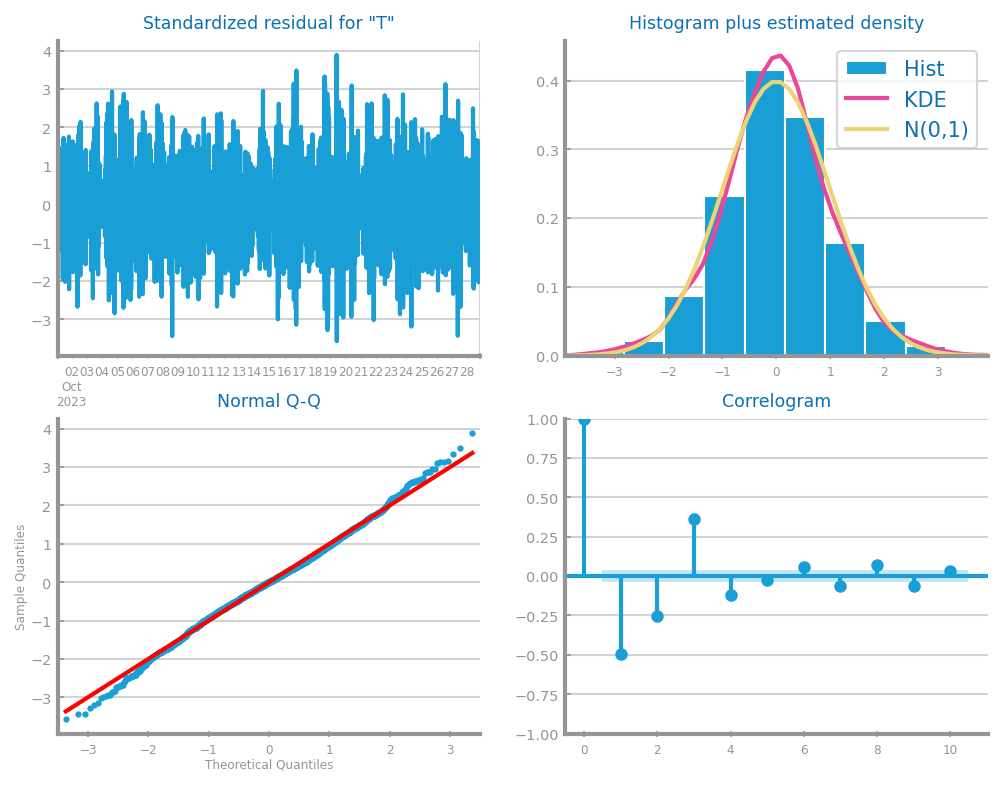

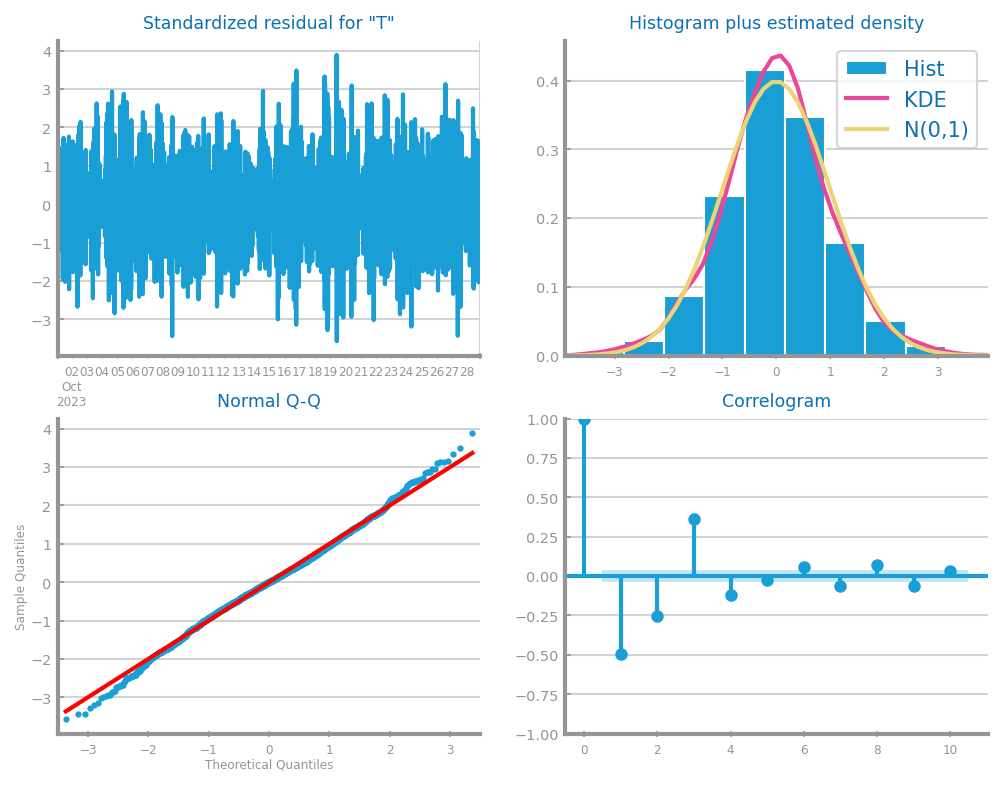

In [132]:
model.plot_diagnostics(figsize=(2 * dslabs.HEIGHT, 1.5 * dslabs.HEIGHT))

In [135]:
def arima_study(train: pd.Series, test: pd.Series, measure: str = "R2"):
    d_values = (0, 1, 2, 3)
    p_params = (1, 2, 3, 5, 6, 7, 10)
    q_params = (1, 3, 4, 5, 7, 9)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * dslabs.HEIGHT, dslabs.HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = dslabs.FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        dslabs.plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

ARIMA best results achieved with (p,d,q)=(2, 0, 7) ==> measure=0.10


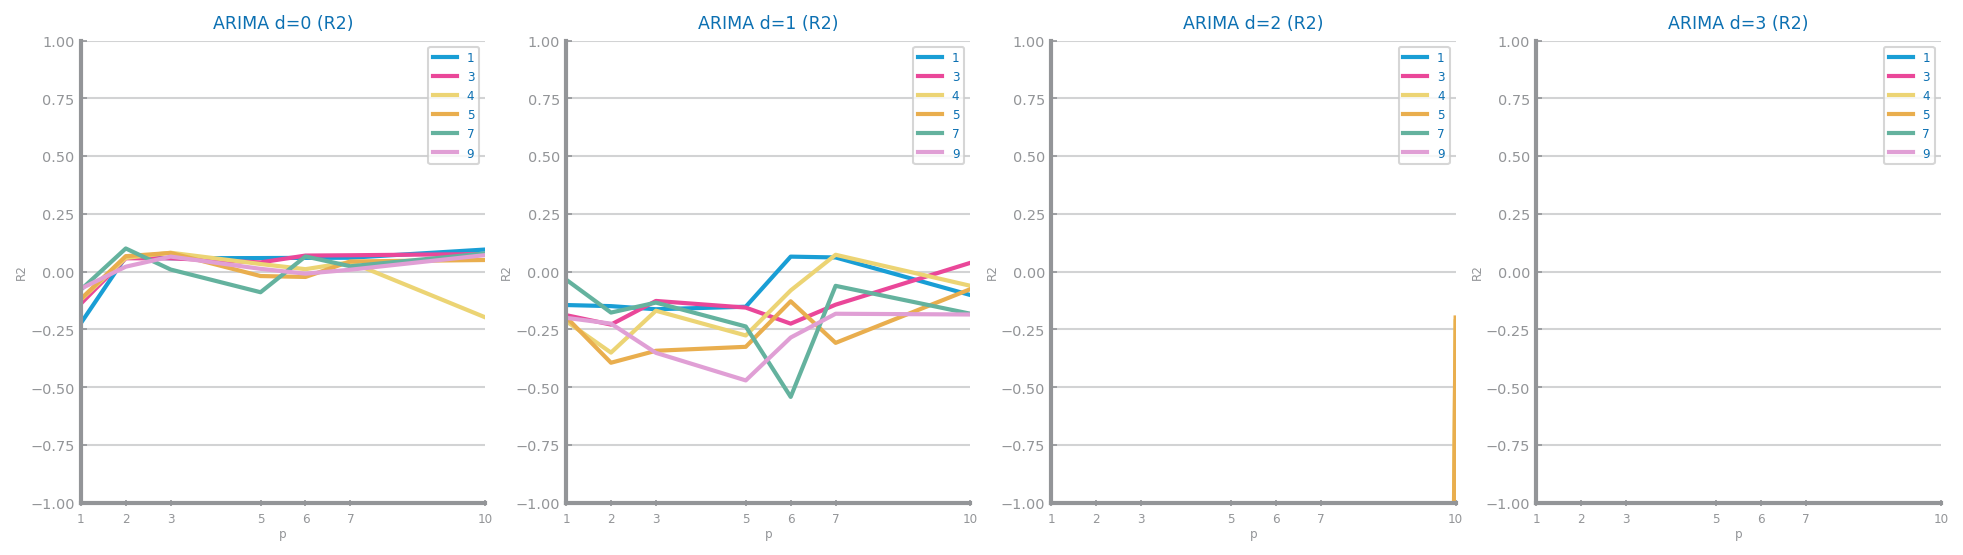

In [136]:
measure: str = "R2" ## R2 ou outra measure
best_model, best_params = arima_study(train, test, measure=measure)

{'RMSE': [2.9590861954008734, 40.595140072408405], 'MAE': [2.0760423525314944, 34.482604083690326]} {'MAPE': [0.0219527957104476, 0.40760797445650426], 'R2': [0.9960563897236256, 0.09990778103714082]}


array([<Axes: title={'center': 'Scale-dependent error'}>,
       <Axes: title={'center': 'Percentage error'}>], dtype=object)

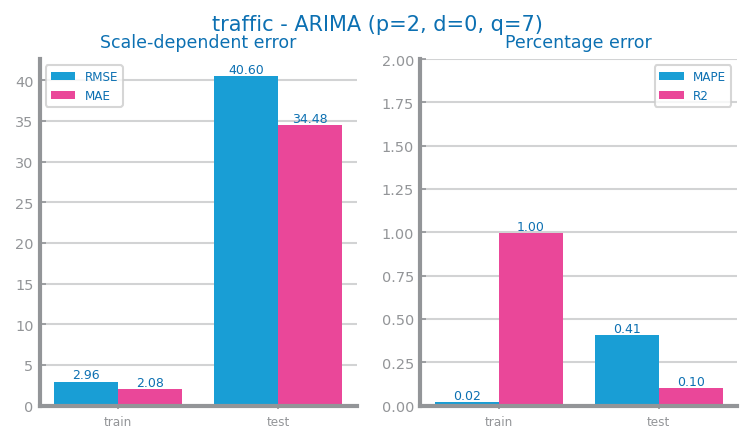

In [137]:
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

### mudar range desta funcao
dslabs.plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)

<Axes: xlabel='TimeStamp', ylabel='Total'>

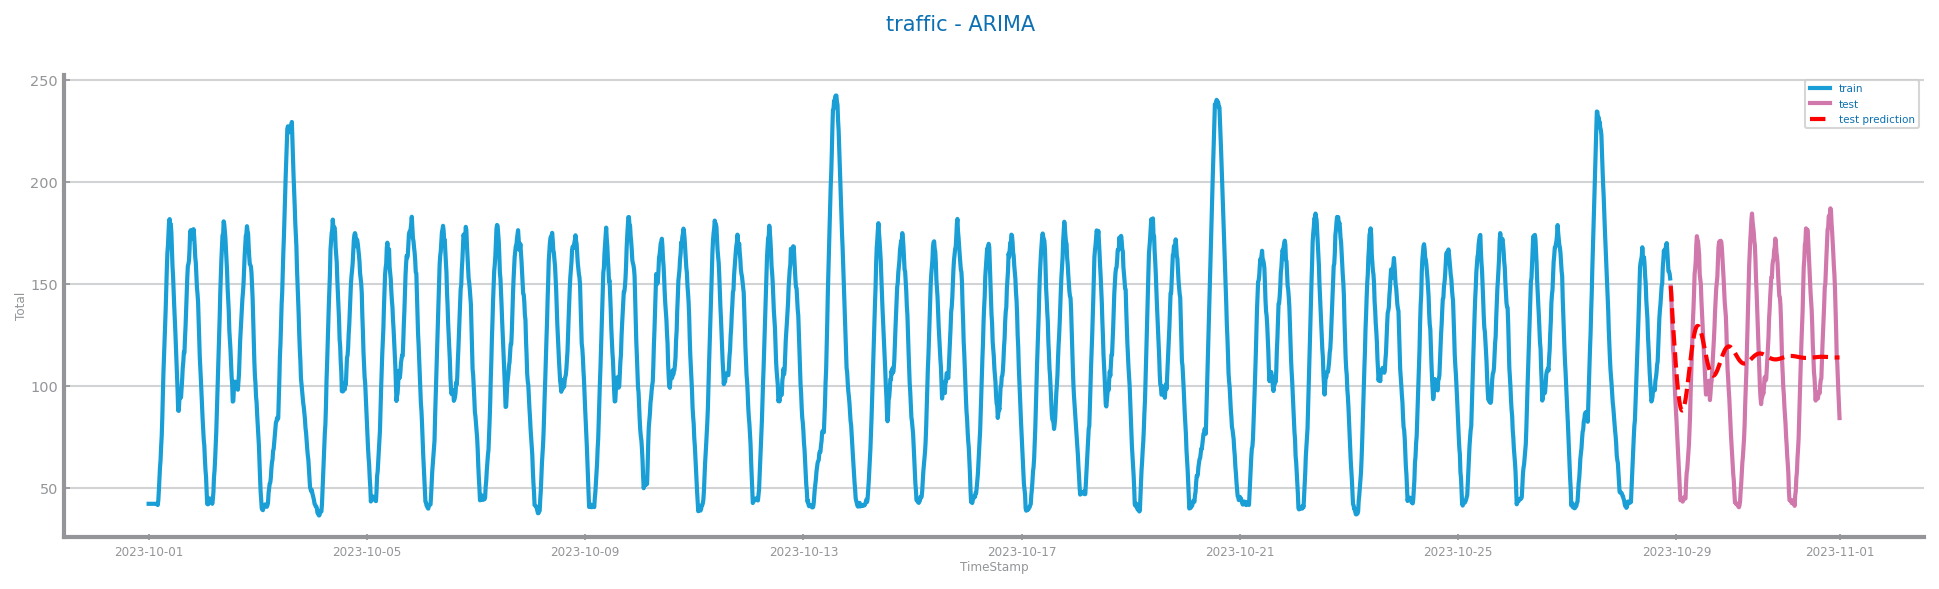

In [138]:
dslabs.plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel="TimeStamp",
    ylabel=target,
)

## LSTMs

In [6]:
import torch

def prepare_dataset_for_lstm(series, seq_length: int = 4):
    setX: list = []
    setY: list = []
    for i in range(len(series) - seq_length):
        past = series[i : i + seq_length]
        future = series[i + 1 : i + seq_length + 1]
        setX.append(past)
        setY.append(future)
    return tensor(setX), tensor(setY)
    #return tensor(setX, dtype=torch.float32), tensor(setY, dtype=torch.float32)


class DS_LSTM(Module):
    def __init__(self, train, input_size: int = 1, hidden_size: int = 50, num_layers: int = 1, length: int = 4):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = Linear(hidden_size, 1)
        self.optimizer = Adam(self.parameters())
        self.loss_fn = MSELoss()

        trnX, trnY = prepare_dataset_for_lstm(train, seq_length=length)
        self.loader = DataLoader(TensorDataset(trnX, trnY), shuffle=True, batch_size=len(train) // 10)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

    def fit(self):
        self.train()
        for batchX, batchY in self.loader:
            y_pred = self(batchX)
            loss = self.loss_fn(y_pred, batchY)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return loss

    def predict(self, X):
        with no_grad():
            y_pred = self(X)
        return y_pred[:, -1, :]

In [7]:
measure: str = "R2"

series_data = data_scaled[[target]].values.astype("float32")
train_size = int(len(series_data) * 0.90)
train, test = series_data[:train_size], series_data[train_size:]

In [8]:
model = DS_LSTM(train, input_size=1, hidden_size=50, num_layers=1)
loss = model.fit()
print(loss)

tensor(0.5419, grad_fn=<MseLossBackward0>)


In [9]:
def lstm_study(train, test, nr_episodes: int = 1000, measure: str = "R2"):
    sequence_size = [2, 4, 8]
    nr_hidden_units = [25, 50, 100]

    step: int = nr_episodes // 10
    episodes = [1] + list(range(0, nr_episodes + 1, step))[1:]
    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "LSTM", "metric": measure, "params": ()}
    best_performance: float = -100000

    _, axs = subplots(1, len(sequence_size), figsize=(len(sequence_size) * dslabs.HEIGHT, dslabs.HEIGHT))

    for i in range(len(sequence_size)):
        length = sequence_size[i]
        tstX, tstY = prepare_dataset_for_lstm(test, seq_length=length)

        values = {}
        for hidden in nr_hidden_units:
            yvalues = []
            model = DS_LSTM(train, hidden_size=hidden)
            for n in range(0, nr_episodes + 1):
                model.fit()
                if n % step == 0:
                    prd_tst = model.predict(tstX)
                    eval: float = dslabs.FORECAST_MEASURES[measure](test[length:], prd_tst)
                    print(f"seq length={length} hidden_units={hidden} nr_episodes={n}", eval)
                    if eval > best_performance and abs(eval - best_performance) > dslabs.DELTA_IMPROVE:
                        best_performance: float = eval
                        best_params["params"] = (length, hidden, n)
                        best_model = deepcopy(model)
                    yvalues.append(eval)
            values[hidden] = yvalues
        dslabs.plot_multiline_chart(
            episodes,
            values,
            ax=axs[i],
            title=f"LSTM seq length={length} ({measure})",
            xlabel="nr episodes",
            ylabel=measure,
            percentage=flag,
        )
    print(
        f"LSTM best results achieved with length={best_params["params"][0]} hidden_units={best_params["params"][1]} and nr_episodes={best_params["params"][2]}) ==> measure={best_performance:.2f}"
    )
    return best_model, best_params

seq length=2 hidden_units=25 nr_episodes=0 0.016287315550030157
seq length=2 hidden_units=25 nr_episodes=30 0.9661379138925981
seq length=2 hidden_units=25 nr_episodes=60 0.9872724737892343
seq length=2 hidden_units=25 nr_episodes=90 0.9895158542968773
seq length=2 hidden_units=25 nr_episodes=120 0.9907843564014628
seq length=2 hidden_units=25 nr_episodes=150 0.9916967878205921
seq length=2 hidden_units=25 nr_episodes=180 0.9924405998935314
seq length=2 hidden_units=25 nr_episodes=210 0.9932031753316906
seq length=2 hidden_units=25 nr_episodes=240 0.9937576186123489
seq length=2 hidden_units=25 nr_episodes=270 0.9941968408059487
seq length=2 hidden_units=25 nr_episodes=300 0.9940811531030087
seq length=2 hidden_units=50 nr_episodes=0 0.06444429060671764
seq length=2 hidden_units=50 nr_episodes=30 0.9697796423997329
seq length=2 hidden_units=50 nr_episodes=60 0.9880693718769373
seq length=2 hidden_units=50 nr_episodes=90 0.9899230334332755
seq length=2 hidden_units=50 nr_episodes=120 0.

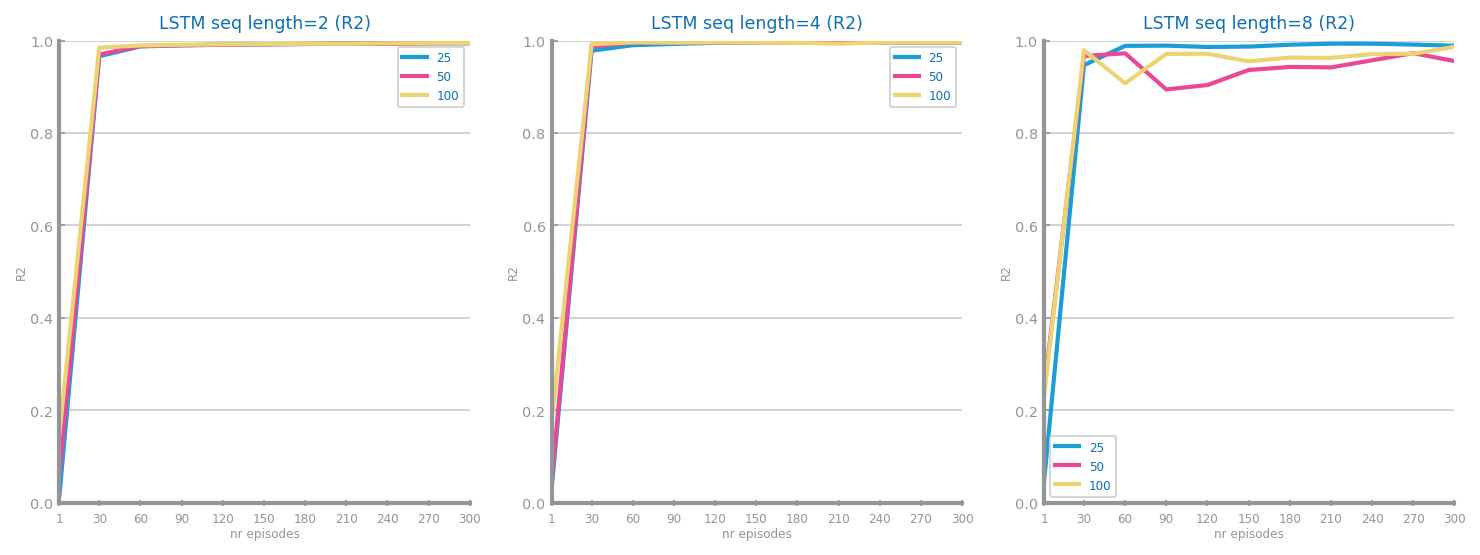

In [10]:
best_model, best_params = lstm_study(train, test, nr_episodes=300, measure=measure)

{'RMSE': [0.03565878942193273, 0.03438953456781274], 'MAE': [0.027887499, 0.027274871]} {'MAPE': [28177316000.0, 0.3432837], 'R2': [0.9964230808961438, 0.9960073657199146]}


<Axes: xlabel='TimeStamp', ylabel='Total'>

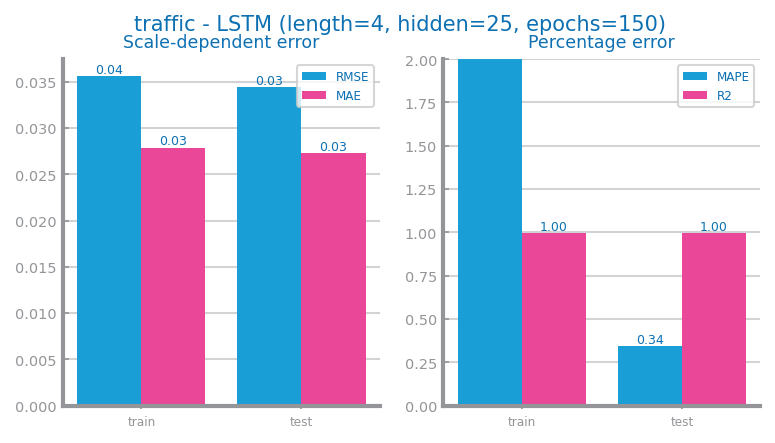

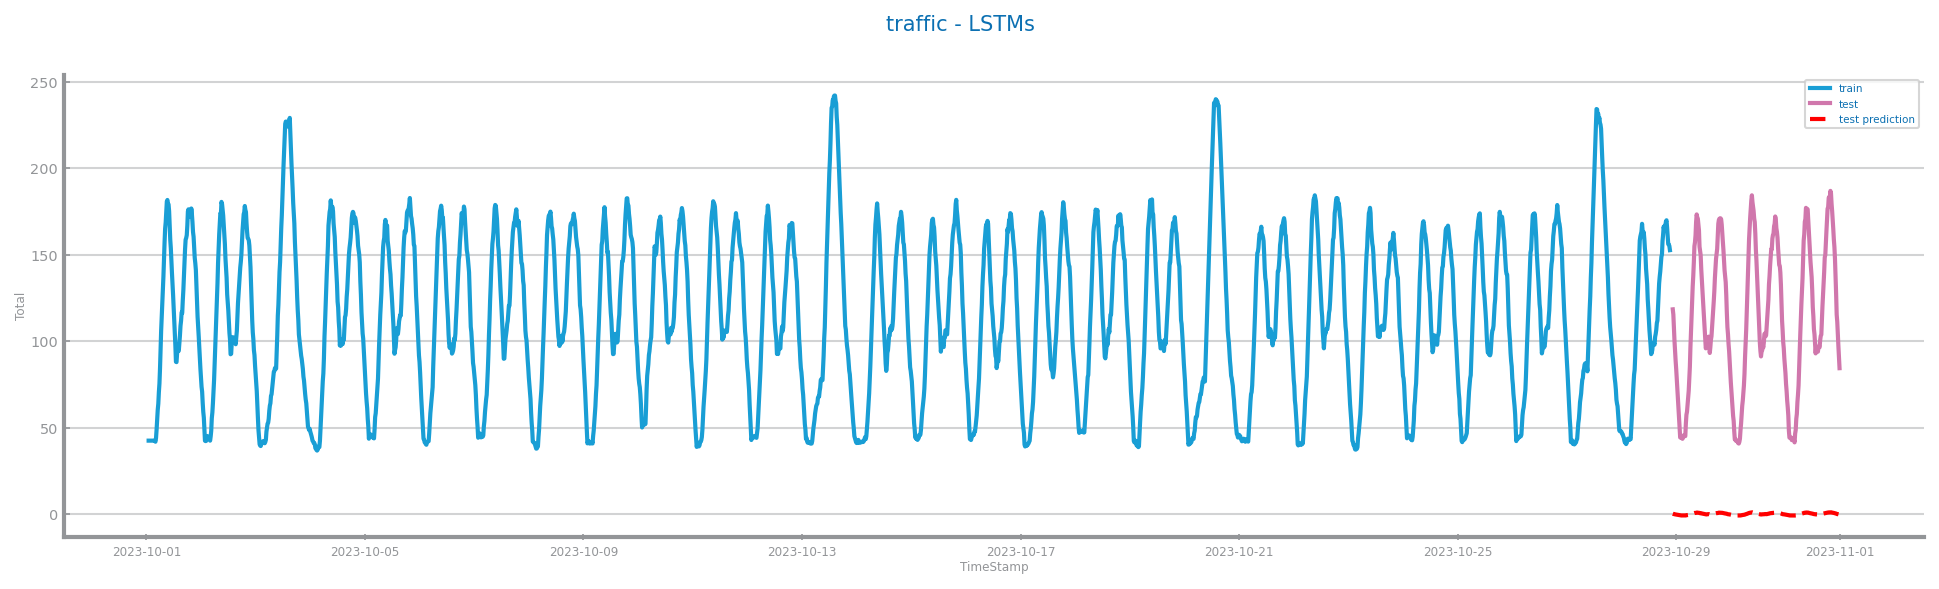

In [11]:
params = best_params["params"]
best_length = params[0]
trnX, trnY = prepare_dataset_for_lstm(train, seq_length=best_length)
tstX, tstY = prepare_dataset_for_lstm(test, seq_length=best_length)

prd_trn = best_model.predict(trnX)
prd_tst = best_model.predict(tstX)

dslabs.plot_forecasting_eval(
    train[best_length:],
    test[best_length:],
    prd_trn,
    prd_tst,
    title=f"{file_tag} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]})",
)

series2 = data[[target]]
train, test = series2[:train_size], series2[train_size:]
pred_series: pd.Series = pd.Series(prd_tst.numpy().ravel(), index=test.index[best_length:])

dslabs.plot_forecasting_series(
    train[best_length:],
    test[best_length:],
    pred_series,
    title=f"{file_tag} - LSTMs ",
    xlabel="TimeStamp",
    ylabel=target,
)